# DEEPLEARNING
---

# 0. Librería

## 0.1. Libreria Específicas Para Neuroimagenes
---

nibabel
---
Repositorio:
https://nipy.org/nibabel/

Es la librería base en Python para leer, escribir y manipular archivos de neuroimagen médica (NIfTI, Analyze, DICOM, MGH).
- Lee y guarda imágenes NIfTI (.nii y .nii.gz)
- Permite acceder a los datos brutos como arrays NumPy.
- Permite modificar headers, orientaciones, resoluciones, affine matrices.
- Ideal para preprocesamientos bajos o personalizados.

Como se utiliza en este proyecto:
- Toda imagen médica que descargues estará en formato NIfTI.
- Permite convertir imágenes a arrays NumPy para machine learning.
- Es la base sobre la que trabajan nilearn y ANTsPy.
  
ants
---
Repositorio:
https://github.com/ANTsX/ANTsPy

Instalación:
pip install antspyx

Es la versión en Python del famoso software ANTs (Advanced Normalization Tools), desarrollado para el registro espacial y procesamiento avanzado de imágenes médicas, especialmente neuroimagen.
Es una de las librerías más robustas y validadas científicamente en neuroimagen

Permite implementar de manera programática:
- Registro de imágenes (rigido, afín, no lineal SyN).
- Aplicar transformaciones.
- Normalización espacial.
- Operaciones matemáticas sobre imágenes (resampling, smoothing, etc.)
- Extracción de templates.
- Creación de campos de deformación.

Como se utiliza en este proyecto:
- Coregistrar fRMI y RMI.
- Alinear a MNI estándar.
- Transformar máscaras y ROIs entre espacios.
- Estudiar la morfología cerebral.

nilearn
---
Repositorio:
https://nilearn.github.io/

Es una librería de alto nivel pensada para:
- Visualización interactiva de neuroimágenes.
- Machine Learning sobre imágenes cerebrales.
- Extracción de ROIs y máscaras.
- Análisis estadístico de imágenes fMRI.
- Trabajo sencillo con imágenes en espacio MNI.
- Dibuja imágenes cerebrales en 2D y 3D.
- Superpone imágenes funcionales sobre anatómicas.
- Carga y gestiona máscaras, atlas y ROIs.
- Facilita el análisis de series temporales fMRI.
- Prepara datos para machine learning (Matrices feature X target).

Como se utiliza en este proyecto:
- Para visualizar resultados en notebooks.
- Para generar reportes automáticos.
- Para crear datasets a partir de RMI y fRMI procesados.
- Para graficar mapas cerebrales, conectividad y activaciones.



In [1]:
# Librerias específicas de Tratamiento de imágenes RMI y fRMI
import ants  # instalar con pip install antspyx
import nibabel as nib
from nilearn.plotting import plot_anat, plot_epi

from nilearn import datasets


## 0.2. Librerías Monai
---
Librería Monai utilizada para implementar Transfer Learning utilizando modelos de arquitectura ViT preentrenados en bases de datos médicas

In [2]:
from monai.apps import download_url, load_from_mmar
from monai.networks.nets import ViT, VISTA3D, SwinUNETR

from monai.transforms import (
    LoadImaged,  ConcatItemsd, Spacingd, Orientationd,
    ScaleIntensityRanged, EnsureTyped
)

## 0.3. Librerías del Framework Pytorch

In [3]:
# Librerías Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import (
    WeightedRandomSampler, DataLoader,
    Dataset, Subset, random_split
)

from torch.amp import autocast, GradScaler

# Librerías Utilidades para Torch
from torchinfo import summary



## 0.4. Librerías generales de Python

In [4]:
# Librerias de Sistema
import subprocess
import os
import time
# Gestión de imágenes y Gráficos
from PIL import Image  
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Pandas
import pandas as pd

# Numpy
import numpy as np
# Librerias de Scikit-Learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve,
    classification_report
)



## 0.5. Inicialización del Entorno

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mem_stats(debug = False):
    mem = torch.cuda.memory_allocated() / (1024 ** 2)
    peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
    mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2) 
    if debug:
        print('Torch Version:', torch.__version__)
        print('Device:', torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    print(f"GPU Memory -->  Usage: {mem:.2f} MB | Peak: {peak:.2f} MB| Reserved: {mem_reserved:.2f} MB")

mem_stats(debug = True)

Torch Version: 2.5.1
Device: cuda
GPU Memory -->  Usage: 0.00 MB | Peak: 0.00 MB| Reserved: 0.00 MB


# 1. Dataset
----


## 1.1. Tranformaciones

In [6]:
transforms_monai = [
    LoadImaged(keys=['t1','t1ce','t2','flair']),
    #AddChanneld(keys=['t1','t1ce','t2','flair']),
    Spacingd(keys=['t1','t1ce','t2','flair'], pixdim=(1.0,1.0,1.0), mode=('bilinear')),
    Orientationd(keys=['t1','t1ce','t2','flair'], axcodes='RAS'),
    ScaleIntensityRanged(
        keys=['t1','t1ce','t2','flair'],
        a_min=0, a_max=3000,
        b_min=0.0, b_max=1.0,
        clip=True,
    ),
    ConcatItemsd(keys=['t1','t1ce','t2','flair'], name='image'),
    EnsureTyped(keys=['image'])
]

## 1.2. Dataset

In [7]:

class CustomNIIDataset(Dataset):
    def __init__(self, 
                 device, 
                 path_base, 
                 path_filedata, 
                 binaria = True,
                 transform = None, 
                 output_shape = (128, 128, 128),
                 filter_target = None,
                 arquitecture = 'CNN',
                 segment = False,
                 segment_base = (0,0,0),
                 segment_size = 16,
                 data_memory = False
                ):
        self.path_base   = path_base
        self.df_targets = pd.read_csv(path_filedata)
        self.transform  = transform
        self.binaria = binaria
        self.filter_target = filter_target
        self.arquitecture = arquitecture
        self.segment = segment
        self.segment_base = segment_base
        self.segment_size = segment_size
        self.data_memory = data_memory
        # Cargar todos los paths
        self._all_paths = []
        self._all_targets = []
        self._all_types = []
        self._all_ID = []
        self._all_hoja = []

        self._load_all_samples()

        # Inicialización: dataset sin filtrar
        self.output_shape = output_shape  # ( H, W, D)
        self.device = device
        
    def _load_all_samples(self):
        n_subjects = 0
        n_seasons = 0    
        n_samples = 0
        n_samples_added = 0
        n_error = 0
        for subj in os.listdir(self.path_base):
            subj_path = os.path.join(self.path_base, subj)
            if not os.path.isdir(subj_path):
                continue

            try:
                subj_num = int(subj.split('-')[1])
            except:
                continue
            
            targets_min = self.df_targets['target'].min()
            n_subjects += 1
            for ses in os.listdir(subj_path):
                n_seasons += 1
                ses_path = os.path.join(subj_path, ses)
                if not os.path.isdir(ses_path):
                    continue

                try:
                    hoja_num = int(ses.split('wave')[1])
                except:
                    continue

                mask = (self.df_targets['S#'] == subj_num) & (self.df_targets['hoja'] == hoja_num)
                if mask.sum() == 0:
                    #print('Warning: No target found for this sample:', ses_path) 
                    n_error +=1
                    continue
                                
                targets = self.df_targets.loc[mask, 'target'].values
                if (len(targets)>0):
                    target = targets[0]
                    if (self.filter_target is not None and target in self.filter_target):
                        add_sample = False
                    else:
                        add_sample = True
                    target = target - targets_min
                    if self.binaria:
                        # Binarizar target
                        target = 1 if target < 3 else 0

                for tipo in os.listdir(ses_path):
                    tipo_path = os.path.join(ses_path, tipo)
                    if not os.path.isdir(tipo_path):
                        continue

                    for fname in os.listdir(tipo_path):
                        if fname.endswith('.nii') or fname.endswith('.nii.gz'):
                            n_samples +=1
                            if add_sample:
                                n_samples_added += 1
                                path = os.path.join(tipo_path, fname)
                                self._all_paths.append(path)
                                self._all_targets.append(target)
                                self._all_types.append(tipo)
                                self._all_ID.append(subj_num)
                                self._all_hoja.append(hoja_num)
        
        print('\nTotal Pacientes en la base de Datos:    ', n_subjects, ' (Seasons =',n_seasons,')')
        print('Muestras Descartadas por falta de Target: ', n_error)
        print('Total Muestras en la base de datos:       ', n_samples)
        if self.filter_target is not None:
            print('--> Dataset Filtrado por Targets Eliminados=', self.filter_target,':',n_samples_added, 'muestras')
   
    def filter_clase(self, clase):
        """Filtra self.paths conservando solo aquellos cuyo nombre de archivo contiene la clase de archivo"""
        indices_filtrados = [
                               i for i, path in enumerate(self.paths) if clase in os.path.basename(path)
                          ]
        
        self.paths   = [self.paths[i] for i in indices_filtrados]
        self.targets = [self.targets[i] for i in indices_filtrados]
        self.types   = [self.types[i] for i in indices_filtrados]
        self.ID      = [self.ID[i] for i in indices_filtrados]
        self.hoja    = [self.hoja[i] for i in indices_filtrados]
        print(f'--> Dataset filtrado por clase="{clase}": {len(self.paths)} muestras.')
        
    def filter_tipo(self, tipos):
        """Filtra el dataset para incluir solo ciertos tipos (str o lista de str)"""
        if isinstance(tipos, str):
            tipos = [tipos]  # convertir a lista si es string único

        indices = [i for i, t in enumerate(self._all_types) if t in tipos]

        self.paths   = [self._all_paths[i] for i in indices]
        self.targets = [self._all_targets[i] for i in indices]
        self.types   = [self._all_types[i] for i in indices]
        self.ID      = [self._all_ID[i] for i in indices]
        self.hoja    = [self._all_hoja[i] for i in indices]
        
        print(f'--> Dataset filtrado por tipos={tipos}: {len(self.paths)} muestras.')

    def reset_filter(self):
        """Restaura el dataset completo (sin filtros)"""
        self.paths = list(self._all_paths)
        self.targets = list(self._all_targets)
        self.types = list(self._all_types)
        self.ID = list(self._all_ID)
        self.hoja = list(self._all_hoja)

        print(f'--> Filtro reseteado: {len(self.paths)} muestras activas.')


    def resize_or_pad(self, data):
        #data = torch.from_numpy(data).unsqueeze(0).float()  # [1, H, W, D]

        # Resize con interpolación si tamaño es diferente
        data = F.interpolate(data.unsqueeze(0), size=self.output_shape, mode='trilinear', align_corners=False)
        data = data.squeeze(0) 
        return data  # [1, D, H, W]

    def preload_all_to_gpu(self):
        """Carga todas las muestras en memoria GPU"""
        self._data_gpu = []
        mem_stats()
        for idx in range(len(self.paths)):
            print('.', end='')
            path = self.paths[idx]
            try:
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
                # Normalización z-score
                data = (data - np.mean(data)) / (np.std(data) + 1e-8)
                data = torch.from_numpy(data).unsqueeze(0).float()
                
                if torch.isnan(data).any():
                    raise ValueError(f' El tensor contiene NaNs en el archivo: {path}')
                if torch.isinf(data).any():
                    raise ValueError(f' El tensor contiene Inf en el archivo: {path}')
            except:
                print('archivo corrupto:',path)
                path = self.paths[0]
                target = self.targets[0]
                tipo = self.types[0]
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
            sbase = [b * self.segment_size for b in self.segment_base]
            if self.segment:
                for ix, base in enumerate(sbase):
                    if (base + self.segment_size > data.shape[ix+1]):
                        sbase[ix] = data.shape[ix+1] - self.segment_size
                    if sbase[ix] < 0:
                        sbase[ix] = 0
                    
                W0, H0, D0 = sbase
                S = self.segment_size
                data = data[:,W0:W0+S, H0:H0+S, D0:D0+S]
            self._data_gpu.append(data) 

        self._data_gpu = torch.stack(self._data_gpu).to(self.device)
        print('\nDatos cargados en Memoria:',len(self.paths))
        mem_stats()
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path   = self.paths[idx]
        target = self.targets[idx]
        tipo   = self.types[idx]
        ID     = self.ID[idx]
        hoja   = self.hoja[idx]

        if self.data_memory:
            data = self._data_gpu[idx]
        else:
            nii_img = nib.load(path)
            try:
                data = nii_img.get_fdata(dtype=np.float32)
                        # Normaliza a rango 0-1
                data = (data - np.mean(data)) / (np.std(data) + 1e-8)
                data = torch.from_numpy(data).unsqueeze(0).float()
                if torch.isnan(data).any():
                    raise ValueError(f' El tensor contiene NaNs en el archivo: {path}')
                if torch.isinf(data).any():
                    raise ValueError(f' El tensor contiene Inf en el archivo: {path}')
            except:
                print('archivo corrupto:',path)
                path = self.paths[0]
                target = self.targets[0]
                tipo = self.types[0]
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
            sbase = [b * self.segment_size for b in self.segment_base]
            if self.segment:
                for ix, base in enumerate(sbase):
                    if (base + self.segment_size > data.shape[ix+1]):
                        sbase[ix] = data.shape[ix+1] - self.segment_size
                    if sbase[ix] < 0:
                        sbase[ix] = 0
                    
                W0, H0, D0 = sbase
                S = self.segment_size
                data = data[:,W0:W0+S, H0:H0+S, D0:D0+S]
            data = data.to(self.device)
        if self.arquitecture == 'CNN' or self.arquitecture == 'VIT'or self.arquitecture == 'MONAI':
            if len(data.shape) == 5: 
                #data = data[:,:,:,:,data.shape[-1]/2]
                #data = data.mean(-1)
                rand = np.random.randint(0, data.shape[-1])
                data = data[:,:,:,:,rand]
            if self.output_shape is not None:
                data = data[:,:self.output_shape[0],:self.output_shape[1], :]
                # Resize/Padding a tamaño uniforme
                #data = self.resize_or_pad(data)
                if self.output_shape[2] - data.shape[3]> 0:
                    data = F.pad(data, (0, self.output_shape[2] - data.shape[3])) 
                if self.output_shape[2] - data.shape[3] < 0:
                    data = data[:,:,:,:self.output_shape[2]]
            
        if self.transform:
            data = self.transform(data)
        
        
        target = torch.tensor(target, dtype=torch.long).to(self.device)
        
        return data, target, tipo, ID, hoja


In [8]:
def build_Datasets(dataset_config, split_config):

    # -------- Crea el Dataset Con Todas las Muestras en Path Base --------
    dataset = CustomNIIDataset(**dataset_config)
    # -------- Filtra las muestras y se queda solo con las muestras --------
    # -------- de la/s carpeta/s en FilterData --------
    if split_config['filter_tipo'] is not None:
        dataset.filter_tipo(split_config['filter_tipo'])
    else:
        dataset.reset_filter()
    if split_config['filter_clase'] is not None:
        dataset.filter_clase(split_config['filter_clase'])

    if split_config['dataset_demo']:
        dataset = Subset(dataset, list(range(split_config['dataset_demosize'])))
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
        print('Demo Mode. Total de Muestras:',len(targets))
    else:
        targets = dataset.targets

    if dataset_config['data_memory']:
        if split_config['dataset_demo']:
            dataset.dataset.preload_all_to_gpu()
        else:
            dataset.preload_all_to_gpu()
    
    # -------- Divde las muestras en 3 Datasets: Train, Valid, Test --------

    # Cálculo de tamaños
    total_size = len(dataset)
    
    train_size = int(split_config['split'][0] * total_size)
    test_size = int(split_config['split'][1] * total_size)
    valid_size = total_size - train_size - test_size  # el resto

    # División reproducible
    if split_config['seed'] is not None:
        generator = torch.Generator().manual_seed(split_config['seed'])
    else:
        generator = None
    
    train_dataset, test_dataset, valid_dataset = random_split(
        dataset,
        [train_size, test_size, valid_size],
        generator=generator
    )

    datasets_dict = {
        'train' : train_dataset,
        'valid' : valid_dataset,
        'test'  : test_dataset,
        'global': dataset
    }
    
    print(f"Dataset Global: {len(datasets_dict['global'])}")
    print(f"Datasets Creados --> train: {len(datasets_dict['train'])}, valid: {len(datasets_dict['valid'])}, test: {len(datasets_dict['test'])}") 
    print('Dimensiones de las muestras: ',list(next(iter(datasets_dict['train']))[0].shape))

    return datasets_dict, targets
    



In [9]:
# PARAMETROS DATASET
NUM_CLASSES = 1 # len(np.unique(targets))
ARQUITECTURE = 'VIT'
DATASET_CONFIG = {
    "device": DEVICE,
    "path_base": r"C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0",
    #"path_base": r"V:\\Datasets\\Dallas\\processed",
    #"path_base": r"V:\Datasets\Dallas\ds004856-1.2.0",
    #"path_base": r"G:\Mi unidad\04.Datasets\Dallas\ds004856-1.2.0",
    "path_filedata": 'DatosCompletos.csv',
    "binaria": True,
    "transform": None,  
    "output_shape":  (64,64,64), #None, # (128, 128, 111),   # Original: (512, 512, 64)  #Preprocesado: (197, 233, 189)   (512, 512, 64) 
    # Bold: (64, 64, 43, 211) -->
    # func: [1, 64, 64, 43, 154] --> [154, 176128] (RNN)
    "filter_target": [27,28,29 ], 
    "arquitecture" : ARQUITECTURE, # 'CNN', 'RNN', 'RAW'
    'segment'      : False,
    'segment_base' : [4,6,3],
    'segment_size' : 8,
    'data_memory'  : False

}
SPLIT_CONFIG = {
    "filter_tipo":  ['func'],
    "filter_clase": 'VentralVisual', #'Scene', #'FLAIR'
    "dataset_demo": False,
    "dataset_demosize": 64,
    "split": (0.8, 0.15),
    "seed": 42
}

In [10]:
print('\nPath Dataset:', DATASET_CONFIG['path_base'])
print('File Data:', DATASET_CONFIG['path_filedata'],'\n')

datasets_dict, targets = build_Datasets(DATASET_CONFIG, SPLIT_CONFIG)
# Mostrar longitud
print(f"\nNúmero total de muestras en el dataset: {len(targets)}\n")
print(f"Train : {len(datasets_dict['train'])}")
print(f"Test  : {len(datasets_dict['test'])}")
print(f"Valid : {len(datasets_dict['valid'])}")

# Visualizar las primeras muestras
print('\nMostrando algunas muestras del dataset de entrenamiento:\n')

for idx, (data, target, tipo, ID, hoja) in enumerate(datasets_dict['train']):
    print(f'Muestra {idx}')
    print(f'- Shape del tensor: {data.shape}')
    print(f'- Target asociado : {target.item()}')
    print(f'- Tipo encontrado : {tipo}')
    print(f'- ID de Ususario  : {ID}')
    print(f'- Wave (hoja)     : {hoja}')
        
    print('----------------------------')

    if idx >= 4:  # Mostrar solo las 5 primeras
        break


Path Dataset: V:\Datasets\Dallas\ds004856-1.2.0
File Data: DatosCompletos.csv 


Total Pacientes en la base de Datos:     464  (Seasons = 969 )
Muestras Descartadas por falta de Target:  15
Total Muestras en la base de datos:        9764
--> Dataset Filtrado por Targets Eliminados= [27, 28, 29] : 4322 muestras
--> Dataset filtrado por tipos=['func']: 3000 muestras.
--> Dataset filtrado por clase="VentralVisual": 448 muestras.
Dataset Global: 448
Datasets Creados --> train: 358, valid: 23, test: 67
Dimensiones de las muestras:  [1, 64, 64, 64]

Número total de muestras en el dataset: 448

Train : 358
Test  : 67
Valid : 23

Mostrando algunas muestras del dataset de entrenamiento:

Muestra 0
- Shape del tensor: torch.Size([1, 64, 64, 64])
- Target asociado : 0
- Tipo encontrado : func
- ID de Ususario  : 784
- Wave (hoja)     : 2
----------------------------
Muestra 1
- Shape del tensor: torch.Size([1, 64, 64, 64])
- Target asociado : 0
- Tipo encontrado : func
- ID de Ususario  : 849
- 

# 2. Modelo

## 1. Definición del modelo CNN 3D


In [11]:
class SEBlock3D(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock3D, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, d, h, w = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1, 1)
        return x * y

In [12]:

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dropout=0.3):
        super(ResidualBlock3D, self).__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.act1 = nn.GELU()

        self.dropout = nn.Dropout3d(dropout)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Skip connection (con ajuste si hay cambio de canales o stride)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

        self.final_act = nn.GELU()

    def forward(self, x):
        #residual = self.shortcut(x)
        #residual = x 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        #out += residual
        return self.final_act(out)

In [13]:
class CNN3DModel(nn.Module):
    def __init__(self, 
                 input_channels=1,
                 n_blocks=4,
                 kernel_size=3,
                 n_kernel_base=16,
                 dropout=0.3,
                 num_classes=2,
                 attention = False):
        super(CNN3DModel, self).__init__()

        self.blocks = nn.Sequential()
        current_channels = input_channels

        for i in range(n_blocks):
            out_channels = n_kernel_base * (2 ** i)
            stride = 2 #if i == 0 else 1  # Reducción de resolución solo al inicio
            res_block = ResidualBlock3D(current_channels, out_channels, kernel_size=kernel_size, stride=stride, dropout=dropout)
            if attention:
                se_block = SEBlock3D(out_channels)
                self.blocks.append(nn.Sequential(res_block, se_block))
            else:
                self.blocks.append(res_block)
            
            current_channels = out_channels

        # Para Grad-CAM, guardamos explícitamente la última convolución
        self.last_conv = nn.Conv3d(current_channels, current_channels, kernel_size=3, padding=1, bias=False)
        self.last_bn = nn.InstanceNorm3d(current_channels,  affine=True) #GroupNorm(num_groups=8, num_channels=current_channels)
        self.last_act = nn.GELU()
        self.adaptive_pool = nn.AdaptiveAvgPool3d(output_size=(2, 2, 2))

        self.classifier = nn.Sequential(
            nn.Linear(current_channels * 2**3, 256 ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear( 256, 64 ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(64 , num_classes)
        )

    def forward(self, x):
        if (len(x.shape)==5):
            x = x[:,:,:,:,:64]
        for block in self.blocks:
            x = block(x)
            
        x = self.last_conv(x)
        x = self.last_bn(x)
        x = self.last_act(x)
        x = self.adaptive_pool(x)  # [B, C, 1, 1, 1]
        x = torch.flatten(x, 1)    # [B, C]
        x = self.classifier(x)
        return x


## 2. Modelo RNN

In [14]:
class RNN3DModel(nn.Module):
    def __init__(self, 
                 input_shape=176128,
                 reduced_size=256,
                 hidden_size=128, 
                 num_layers=1, 
                 rnn_type='LSTM', 
                 rnn_pixel = True,
                 rnn_reducer = False,
                 bidirectional=True, 
                 dropout=0.3,
                 num_classes = 1
                ):
        super().__init__()

        self.rnn_reducer = rnn_reducer
        self.rnn_pixel = rnn_pixel
        if rnn_pixel:
            self.input_shape = 1
        else:
            self.input_shape = input_shape

        if self.rnn_reducer:
            # Reducción de la dimensión espacial
            self.reducer = nn.Sequential(
                nn.Linear(input_size, 2048),  # (B, T, V) -> (B, T, D)
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(2048, 512),  # (B, T, V) -> (B, T, D)
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, reduced_size),  # (B, T, V) -> (B, T, D)
                nn.ReLU(),
                nn.Dropout(0.3)
            )
        
        rnn_cls = nn.LSTM if rnn_type == 'LSTM' else nn.GRU

        self.rnn = rnn_cls(
            input_size    = input_shape,
            hidden_size   = hidden_size,
            num_layers    = num_layers,
            bidirectional = bidirectional,
            dropout       = dropout if num_layers > 1 else 0,
            batch_first   = True
        )
        
        rnn_out_size = hidden_size * (2 if bidirectional else 1)
        
        self.classifier = nn.Sequential(
            nn.Linear(rnn_out_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),  # Binary classification
            #nn.Sigmoid()
        )

    def forward(self, x):  # x: (B,C,H,W,D,T)
        x = x.reshape( x.shape[0], -1, x.shape[-1]).permute(0,2,1)[:128,:] 
        # x: (B,C*H*W*D,T) = (B, V, T)      V:= C*H*W*D
        
        #print(x.shape)
        B, T, V = x.shape
        if self.rnn_reducer:
            x = self.reducer(x)  # → (B, T, V)  --> (B, T, V_reduced)
            B, T, V = x.shape
        if self.rnn_pixel:
              # Reorganizar: cada vóxel es una secuencia (por paciente)
            x = x.permute(0, 2, 1)      # (B, V, T)
            #print(x.shape)
            x = x.reshape(B * V, T, 1)  # (B*V, T, 1)
        #print(x.shape)
        output, _ = self.rnn(x)  # (T, num_voxels, hidden)
        #print(output.shape)
        last_step = output[:, -1, :]  # (B*V, hidden)
        #print(last_step.shape)
        if self.rnn_pixel:
            # Reconstruir batch y pool sobre vóxeles
            last_step = last_step.view(B, V, -1)  # (B, V, hidden)
            #print(last_step.shape)
            #global_rep = last_step.mean(dim=1)   # (B, hidden)  # (num_voxels, hidden)
            
            global_representation = last_step.mean(dim=1)  # (hidden,)
            
        else:
            global_representation = last_step
        #print(global_representation.shape)
        out = self.classifier(global_representation)
        #print(out.shape)
        return 1.0 - out


## 3. Transformer ViT 3D

### 3.1. Transformer ViT 3D

In [15]:
def VIT3DModel_(
        in_channels   = 1,
        img_size      = (64,64,43),
        patch_size    = (16,16,16),
        hidden_size   = 768,
        mlp_dim       = 3072,
        num_layers    = 12,
        num_heads     = 12,
        classification= True,
        num_classes   = 1,
        dropout       = 0.1,
        spatial_dims  = 3
        ):

    model = ViT(
        in_channels   = in_channels,
        img_size      = img_size,
        patch_size    = patch_size,
        hidden_size   = hidden_size,
        mlp_dim       = mlp_dim,
        num_layers    = num_layers,
        num_heads     = num_heads,
        classification= classification,
        num_classes   = num_classes,
        dropout_rate  = dropout,
        spatial_dims  = spatial_dims
    )
    return model


### 3.2 Monai Transfer Learning

In [48]:
class CNNClassifier(nn.Module):
    def __init__(self, in_channels, num_classes=1, dropout = 0.5):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool3d(2),  # Reduce spatial dims by 2

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            # AdaptiveAvgPool3D reduces to [B,64,1,1,1]
            nn.AdaptiveAvgPool3d(1)
        )
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [63]:
def MonaiModel_base(model_name = "brats_mri_segmentation", model_weights = None,dropout = None):
    #model = load_from_mmar(model_name)
    model = SwinUNETR(
        in_channels=1,
        out_channels=14,
        feature_size=48,
        use_checkpoint=True,
    )
    print('Modelo Inicializado:', model_name)
    if model_weights is not None:
        weight = torch.load(model_weights, weights_only=True)
        model.load_from(weights=weight)
        print('Pesos cargados en el modelo:',  model_weights)
        for param in model.parameters():
            param.requires_grad = False
        #for param in model.out.parameters():
        #    param.requires_grad = True
    return model    


In [67]:
class MonaiModel(nn.Module):
    def __init__(self, num_classes=1, model_name = "brats_mri_segmentation", model_weights = None,dropout = 0.0):
        super().__init__()
        self.segmentation_model = MonaiModel_base(model_name = model_name, model_weights = model_weights)
        self.classifier = CNNClassifier(in_channels=14, num_classes=num_classes, dropout = dropout)
        
    def forward(self, x):
        with torch.no_grad():
            seg_out = self.segmentation_model(x)  # [B,14,D,H,W]
        
        out = self.classifier(seg_out)
        return out


## Hiperparámetros

In [68]:
ARQUITECTURE = "MONAI"
# PARAMETROS DEL MODELO
INPUT_SHAPE = list(next(iter(datasets_dict['train']))[0].shape)
print('Número de Clases:', NUM_CLASSES)
print('Input Shape:', INPUT_SHAPE)

MODEL_CONFIG_CNN = {
        "input_channels": 1,
        "n_blocks": 1,
        "kernel_size": 3,
        "n_kernel_base": 16 ,
        "dropout": 0.3,
        "num_classes": NUM_CLASSES,
        "attention": False
        }

MODEL_CONFIG_RNN = {
        "input_shape": INPUT_SHAPE[1]*INPUT_SHAPE[2]*INPUT_SHAPE[3],
        "reduced_size": 256,
        "hidden_size": 128,
        "num_layers": 1,
        "rnn_type": "LSTM",
        "rnn_pixel": False,
        "rnn_reducer": False,
        "bidirectional": False,
        "dropout": 0.3,
        "num_classes": NUM_CLASSES
        }

MODEL_CONFIG_VIT = {
        'in_channels'   : 1,
        'img_size'      : (64,64,64),
        'patch_size'    : (16,16,16),
        'hidden_size'   : 768,
        'mlp_dim'       : 3072,
        'num_layers'    : 12,
        'num_heads'     : 12,
        'classification': True,
        'num_classes'   : 1,
        'dropout'       : 0.1,
        'spatial_dims'  : 3
        }

MODEL_CONFIG_MONAI = {
        'model_name' : "swin_unetr_btcv", # 'brats_mri_segmentation'
        'model_weights' : 'model_swinvit.pt',
        'dropout' : 0.4
        }

MODEL_CONFIG = {
    'CNN' : MODEL_CONFIG_CNN,
    'RNN' : MODEL_CONFIG_RNN,
    'VIT' : MODEL_CONFIG_VIT,
    'MONAI' : MODEL_CONFIG_MONAI
}


def get_Model(arquitecture, model_config):
    if arquitecture == 'CNN':
        return CNN3DModel(**model_config['CNN']).to(DEVICE)
    if arquitecture == 'RNN':
        return RNN3DModel(**model_config['RNN']).to(DEVICE)
    if arquitecture == 'VIT':
        return VIT3DModel(**model_config['VIT']).to(DEVICE)
    if arquitecture == 'MONAI':
        return MonaiModel(**model_config['MONAI']).to(DEVICE)

Número de Clases: 1
Input Shape: [1, 64, 64, 64]


In [69]:
torch.cuda.empty_cache()
model = get_Model(ARQUITECTURE, MODEL_CONFIG)
s,t,_, ID, hoja = next(iter(datasets_dict['global']))
b = s.cpu().unsqueeze(0).to(DEVICE)
if len(INPUT_SHAPE)== 5 and (ARQUITECTURE == 'CNN' or ARQUITECTURE == 'VIT'):
    input_size = (1,*INPUT_SHAPE[:4])
    #b = b[:,:,:,:,0]
else:
    input_size=(1, *INPUT_SHAPE)

print(summary(model, input_size=input_size, col_names=["input_size", "output_size", "num_params", "kernel_size"], depth=4))

#summary(model, input_size=(128, 176128), col_names=["input_size", "output_size", "num_params"], depth=4, device="cpu")
if ARQUITECTURE == 'VIT':
    #b = torch.randn(2,1,64,64,48).to(DEVICE)
    o = model(b)[0]
else:
    o = model(b)
print('Input Size:', list(b.shape), '\tOutput Size:', list(o.shape))
mem_stats()


Modelo Inicializado: swin_unetr_btcv
Pesos cargados en el modelo: model_swinvit.pt
Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape
MonaiModel                                                   [1, 1, 64, 64, 64]        [1, 1]                    --                        --
├─SwinUNETR: 1-1                                             [1, 1, 64, 64, 64]        [1, 14, 64, 64, 64]       --                        --
│    └─SwinTransformer: 2-1                                  [1, 1, 64, 64, 64]        [1, 48, 32, 32, 32]       --                        --
│    │    └─PatchEmbed: 3-1                                  [1, 1, 64, 64, 64]        [1, 48, 32, 32, 32]       --                        --
│    │    │    └─Conv3d: 4-1                                 [1, 1, 64, 64, 64]        [1, 48, 32, 32, 32]       (432)                     [2, 2, 2]
│    │    └─Dropout: 3-2                        

# 3. Entrenamiento

## 3.1. Balanceo de Carga

In [21]:
def balanceo_carga(targets, device):
    # Obtener los targets de tu dataset
    #targets = [dataset.targets[i] for i in range(len(dataset))]
    
    # Contar frecuencia de cada clase
    class_counts = Counter(targets)
    
    # Número total de clases
    num_classes = len(class_counts)
    
    # Crear lista de pesos
    class_weights = []
    
    for i in range(num_classes):
        if class_counts[i] > 0:
            class_weights.append(1.0 / class_counts[i])
        else:
            class_weights.append(1.0 )

    class_weights = torch.FloatTensor(class_weights).to(device)
    return class_weights, class_counts


class_weights, class_counts = balanceo_carga(targets= targets, device = DEVICE)
print(f'Frecuencia por clase: {class_counts}')
print(f'Pesos por clase: list({class_weights})')



Frecuencia por clase: Counter({0: 378, 1: 70})
Pesos por clase: list(tensor([0.0026, 0.0143], device='cuda:0'))


## 3.2. Bucle de Entrenamiento

In [32]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs=20,
    batch_size=16,
    optimizer_type='Adam',
    learning_rate=1e-3,
    loss_type = 'CrossEntropy',
    class_balancing = None,   
    class_balancing_values = None,
    use_early_stopping=False,
    early_stopping_patience=5,
    use_checkpoint = True,
    checkpoint_path='best_model.pth',
    lr_scheduler_type=None,
    regularization=None,  
    l1_lambda=1e-5,
    l2_lambda=1e-4,
    use_autocast = False,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    debug = True
):
    model = model.to(device)
    history = {
        "train_loss": [], "val_loss": [],
        "train_accuracy": [], "val_accuracy": [],
        "epoch_time": [], "epoch_mem": [],
        "auroc": []
    }

    # -------- Optimizer --------
    reg_params = {'params': model.parameters(), 'lr': learning_rate}

    # -------- regularization --------
    if regularization == "L2":
        reg_params["weight_decay"] = 0
    elif regularization == "L1":
        reg_params["weight_decay"] = 0.0  # L1 handled manually
        
    OPTIMIZERS = {
        "Adam": optim.Adam,
        "AdamW": optim.AdamW,
        "SGD": optim.SGD,
        "RMSprop": optim.RMSprop
    }
    if optimizer_type not in OPTIMIZERS:
        raise ValueError("Unsupported optimizer type")
    optimizer = OPTIMIZERS[optimizer_type](**reg_params)

    # -------- Scheduler --------
    scheduler = None
    if lr_scheduler_type == "ReduceLROnPlateau":
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)
    if lr_scheduler_type == "ExponentialLR":
        lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
    if lr_scheduler_type == "CosineAnnealingLR":
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20, eta_min = 1e-7)

        
    if lr_scheduler_type is None:
        lr_scheduler = None
    
    # -------- Loss --------
    LOSS = {
        "CrossEntropy":      nn.CrossEntropyLoss,
        "BCEWithLogitsLoss": nn.BCEWithLogitsLoss,
        "BCELoss": nn.BCELoss,
    #    "FocalLoss":  FocalLoss(),
    }
    if loss_type not in LOSS:
        raise ValueError("Unsupported Loss type")

    # -------- Sampler for class balancing --------
    if class_balancing == "WeightedRandomSampler":
        labels = [train_dataset[i][1] for i in range(len(train_dataset))]
        class_sample_count = torch.tensor([(labels == c).sum() for c in torch.unique(torch.tensor(labels))])
        weight = 1. / class_sample_count.float()
        samples_weight = torch.tensor([weight[l] for l in labels])
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
        criterion = LOSS[loss_type]()
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        
    elif class_balancing == "WeightClass":
        class_weights, _ = balanceo_carga(targets, device = device)
        if NUM_CLASSES == 1:
            class_weights = class_weights[0]/class_weights[1]
        criterion = LOSS[loss_type](pos_weight=class_weights)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        print('--> Balanceo de Carga:',class_balancing, '-->',class_weights)
    
    elif class_balancing == "Manual":
        class_weights = torch.Tensor(class_balancing_values).to(device)
        if NUM_CLASSES == 1:
            class_weights = class_weights[0]/class_weights[1]
        criterion = LOSS[loss_type](pos_weight=class_weights)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        print('--> Balanceo de Carga:',class_balancing, '-->',class_weights)
    
    else:
        criterion = LOSS[loss_type]()
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
    print('--> Numero de Batches de Entrenamiento:', len(train_loader), ' (batch =' ,batch_size,')' )
    # -------- AMP Configuration --------
    if use_autocast and device == 'cuda':
        scaler = torch.amp.GradScaler('cuda')

    
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0

    best_val_auroc = 0 
    for epoch in range(epochs):
        start_time = time.time()
        model.train()

        train_loss, correct, total = 0.0, 0, 0
        for x, y, tipo, ID, hoja in train_loader:
            print('.', end ='')
            x, y = x.to(device), y.to(device)
            if NUM_CLASSES == 1:
                if y.ndim == 2 and y.shape[1] > 1:
                    y = y.argmax(dim=1)  # solo si es one-hot
                y = y.float().unsqueeze(1)  # [B] → [B, 1]
            optimizer.zero_grad()
            if use_autocast and device == 'cuda':
                with torch.autocast(device_type="cuda"):
                    outputs = model(x)
                    if ARQUITECTURE == 'VIT':
                        outputs = outputs[0]
                    #print(outputs.shape, y.shape)
                    loss = criterion(outputs, y)
                    # -------- L1 Regularization --------
                    if regularization in ["L1", "L1L2"]:
                        l1_penalty = sum(torch.sum(p.abs()) for p in model.parameters())
                        loss = loss + l1_lambda * l1_penalty
                
                    if regularization in ["L2", "L1L2"]:
                        l2_penalty = sum(torch.sum(p ** 2) for p in model.parameters())
                        loss = loss + l2_lambda * l2_penalty

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(x)
                #print(outputs.shape, y.shape)
                if ARQUITECTURE == 'VIT':
                    outputs = outputs[0]
                loss = criterion(outputs, y)
                # -------- L1 Regularization --------
                if regularization in ["L1", "L1L2"]:
                    l1_penalty = sum(torch.sum(p.abs()) for p in model.parameters())
                    loss = loss + l1_lambda * l1_penalty
            
                if regularization in ["L2", "L1L2"]:
                    l2_penalty = sum(torch.sum(p ** 2) for p in model.parameters())
                    loss = loss + l2_lambda * l2_penalty


                loss.backward()
                optimizer.step()

            train_loss += loss.item() * x.size(0)
            
            if NUM_CLASSES == 1:
                probs = torch.sigmoid(outputs)      # [B, 1]
                preds = (probs > 0.5).float()       # binariza
                correct += (preds == y).sum().item()
                total += y.size(0)
            else:
                _, predicted = outputs.max(1)
                correct += predicted.eq(y).sum().item()
                total += y.size(0)

        train_loss /= total
        train_acc = correct / total

        # -------- Validation --------
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        torch.cuda.reset_peak_memory_stats()
        all_probs = []
        all_preds = []
        all_targets = []
        all_outputs = []
        with torch.no_grad():
            for x, y, tipo, ID, hoja in val_loader:
                print('.', end ='')
                x, y = x.to(device), y.to(device)
                if NUM_CLASSES == 1:
                    if y.ndim == 2 and y.shape[1] > 1:
                        y = y.argmax(dim=1)  # solo si es one-hot
                    y = y.float().unsqueeze(1)  # [B] → [B, 1]
                if use_autocast and device == 'cuda':
                    with torch.autocast(device_type="cuda"):
                        outputs = model(x)
                        if ARQUITECTURE == 'VIT':
                            outputs = outputs[0]
                        loss = criterion(outputs, y)
                else:
            
                    outputs = model(x)
                    if ARQUITECTURE == 'VIT':
                        outputs = outputs[0]
                    loss = criterion(outputs, y)

                val_loss += loss.item() * x.size(0)

                if NUM_CLASSES == 1:
                    probs = torch.sigmoid(outputs)               # [B, 1] en [0,1]
                    preds = (probs > 0.5).long()                 # binarizar
                    correct += (preds == y.long()).sum().item()
                    total += y.size(0)
                else:
                    _, predicted = outputs.max(1)
                    correct += predicted.eq(y).sum().item()
                    total += y.size(0)
    
                    probs = torch.softmax(outputs, dim=1) 
                    preds = torch.argmax(probs, dim=1) 
                
                all_probs.append(probs.cpu().numpy())
                all_preds.append(preds.cpu().numpy())
                all_targets.append(y.cpu().numpy())
                all_outputs.append(outputs.cpu().numpy())
    
        y_true = np.concatenate(all_targets)
        y_score = np.concatenate(all_probs)
        outputs = np.concatenate(all_outputs)
        
        if NUM_CLASSES > 1:
            auroc = roc_auc_score(y_true, y_score[:, 1])
        else:
            probs = torch.sigmoid(torch.Tensor(outputs)).squeeze(1).cpu().numpy()  # [B]
            y_true = torch.Tensor(y_true).squeeze(1).cpu().numpy()   
            auroc = roc_auc_score(y_true, probs)

        
        mem = torch.cuda.memory_allocated() / (1024 ** 2)
        peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
        mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2) 
        
        
        val_loss /= total
        val_acc = correct / total

        # -------- Scheduler update --------
        if lr_scheduler is not None:
            if lr_scheduler_type == "ReduceLROnPlateau":
                lr_scheduler.step(val_loss)    
            else:
                lr_scheduler.step()
            current_lr = lr_scheduler.optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
            

        elapsed = time.time() - start_time

        print(f"\nEpoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val AUROC: {auroc:.4f}, Time: {elapsed:.2f}s")
        print(f" GPU Memory(cur|peak|res) MB: {mem:.2f} | {peak:.2f} | {mem_reserved:.2f} MB, --> LRate: {current_lr}")
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)
        history["epoch_time"].append(elapsed)
        history["epoch_mem"].append(mem)
        history["auroc"].append(auroc)
        
        # -------- Checkpoint y EarlyStopping --------
        #if np.abs(auroc - 0.5) > best_val_auroc :  
        #    best_val_auroc = np.abs(auroc - 0.5)
        if val_loss < best_val_loss :  
            best_val_loss = val_loss
            patience_counter = 0
            if use_checkpoint:
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'history': history,
                    'model': model
                }
                torch.save(checkpoint, checkpoint_path)
                print(f"-->  Checkpoint guardado: {checkpoint_path}")
        else:
            patience_counter += 1
            if use_early_stopping and patience_counter >= early_stopping_patience:
                print(f" Early stopping en epoch {epoch+1}")
                break

        # -------- Logging --------
        checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'model': model
            }
        torch.save(checkpoint, "final_model.pth")
    return history


## 3.3. Resultados del Entrenamiento

In [33]:

def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Evolución de la pérdida")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evolución de la precisión")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    

## 3.4. Configuración del Entrenamiento

In [34]:
TRAINING_CONFIG = {
    "epochs": 5,
    "batch_size": 8,
    "optimizer_type": "Adam",              # Options: 'Adam', 'AdamW', 'SGD', 'RMSprop' 
    "learning_rate": 1e-4,
    "loss_type": "BCEWithLogitsLoss",            # "CrossEntropy", "BCEWithLogitsLoss"
    "class_balancing": 'WeightClass',       # None, "WeightClass",  "WeightedRandomSampler", 'Manual'
    "class_balancing_values": (0.1, 1),
    "use_early_stopping": False,
    "early_stopping_patience": 8,
    "use_checkpoint": True,
    "checkpoint_path": 'best_model.pth',
    "lr_scheduler_type": None,#  "ReduceLROnPlateau",  # Options: None, "ReduceLROnPlateau",
    "regularization": None, #'L2',                     # Options: None, "L1", "L2"
    "l1_lambda": 1e-5,
    "l2_lambda": 1e-6,
    "use_autocast": False,                      #Options:True, False 
    "debug": True
}

# 4. Evaluación

In [35]:

def validate_model(model, path_checkpoint, test_dataset, batch_size, device, debug = True, save_path = None):
    if (path_checkpoint is not None):
        checkpoint = torch.load(path_checkpoint, weights_only=False, map_location='cpu')
        model = checkpoint['model']
        model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_probs = []
    all_targets = []
    all_outputs = []
    all_ID = []
    all_hoja = []
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print('Numero de Batchs de Test:', len(test_loader))
    
    with torch.no_grad():
        for x, y, tipo, ID, hoja in test_loader:
            print('.',end='')
            x = x.unsqueeze(1).to(device) if x.dim() == 4 else x.to(device)
            y = y.to(device)
            if NUM_CLASSES == 1:
                if y.ndim == 2 and y.shape[1] > 1:
                    y = y.argmax(dim=1)  # solo si es one-hot
                y = y.float().unsqueeze(1)  # [B] → [B, 1]
            outputs = model(x)
            if ARQUITECTURE == 'VIT':
                outputs = outputs[0]
            loss = criterion(outputs, y)
            test_loss += loss.item() * x.size(0)
            if NUM_CLASSES == 1:
                probs = torch.sigmoid(outputs)               # [B, 1]
                preds = (probs > 0.5).long()                # [B, 1]
                correct += (preds == y.long()).sum().item()
                total += y.size(0)
            else:
                _, predicted = outputs.max(1)
                correct += predicted.eq(y).sum().item()
                total += y.size(0)
                
                probs = torch.softmax(outputs, dim=1) 
                preds = torch.argmax(probs, dim=1) 

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_targets.append(y.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
            all_ID.append(ID)
            all_hoja.append(hoja)
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    y_score = np.concatenate(all_probs)
    y_ID = np.concatenate(all_ID)
    y_hoja = np.concatenate(all_hoja)
    outputs = np.concatenate(all_outputs)
        
    avg_loss = test_loss / total
    accuracy = correct / total
        
    class_report = classification_report(y_true, y_pred, zero_division=0, labels=list(range(2)))
    # Métricas
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # ROC y AUROC
    if NUM_CLASSES == 2:
         auroc = roc_auc_score(y_true, y_score[:, 1])
         fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    else:
        probs = torch.sigmoid(torch.Tensor(outputs)).squeeze(1).cpu().numpy()  # [B]
        y_true = torch.Tensor(y_true).cpu().numpy()   
        auroc = roc_auc_score(y_true, probs)
        fpr, tpr, thresholds = roc_curve(y_true, probs)
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    if debug:
        print(class_report)
        print(f'\n Métricas de validación del Dataset Test:')
        print(f"Loss           : {avg_loss:.4f}")
        print(f'Accuracy       : {acc:.4f}')
        print(f'Precision      : {prec:.4f}')
        print(f'Recall         : {rec:.4f}')
        print(f'F1 Score       : {f1:.4f}')
        print(f'AUROC          : {auroc:.4f}')
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title("Matriz de Confusión")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()
    
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('Curva ROC')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    metrics =  {
        "Loss": avg_loss,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "auroc": auroc,
        "cm": cm
        }    
    #df_metrics = pd.DataFrame(metrics)
    #df_metrics.to_csv('metrics.csv')
    if save_path is not None:
       df_results = pd.DataFrame({
            'S#': y_ID,
            'hoja': y_hoja,
            'target': y_true,
            'y_pred': y_pred,
            'y_score': y_score
        }) 
       print(df_results)
       df_results.to_csv(save_path, index=False)
       print('Resultados guardados como:', save_path )
        

    return metrics


In [36]:
VALIDATION_CONFIG = {
    "path_checkpoint": 'best_model.pth',
    "batch_size": 16,
    "device": DEVICE,
    "debug": True
}


In [37]:
"""
metrics = validate_model(
   model=model, 
   test_dataset = datasets_dict['test'], 
   **VALIDATION_CONFIG
  )
"""

"\nmetrics = validate_model(\n   model=model, \n   test_dataset = datasets_dict['test'], \n   **VALIDATION_CONFIG\n  )\n"

# 5. Estudio de Hiperparámetros

In [89]:
def full_Training(dataset_config, split_config, model_config, training_config, arquitecture, device, 
                  dataset_restart = True, dataset_restart_0 = False, model_restart = True, index = 0, datasets_dict = None):
    if dataset_restart or (index==0 and dataset_restart_0):
        datasets_dict, targets = build_Datasets(dataset_config, split_config)

    
    if model_restart:
        model = get_Model(arquitecture, model_config).to(device)
    else:
        checkpoint = torch.load(training_config['checkpoint_path'], weights_only=False, map_location='cpu')
        model = checkpoint['model']
    history = train_model(
            model=model,
            train_dataset = datasets_dict['train'],
            val_dataset = datasets_dict['valid'],
            **training_config
         )
    metrics = validate_model(
           model=model, 
           test_dataset = datasets_dict['test'], 
           **VALIDATION_CONFIG
          )
    return history, metrics, datasets_dict

In [86]:
ARQUITECTURE = 'MONAI'

DATASET_CONFIG['filter_target'] = [ 27, 28,29]
DATASET_CONFIG['output_shape']  = [64,64,64] # None            #[ 128,128,64]
DATASET_CONFIG['segment']       = False
DATASET_CONFIG['segment_base']  = [4,6,3]
DATASET_CONFIG['segment_size']  = 8
DATASET_CONFIG['data_memory']   = False
DATASET_CONFIG['arquitecture']  = ARQUITECTURE

SPLIT_CONFIG["filter_tipo"]       = 'func'
SPLIT_CONFIG["filter_clase"]      = 'VentralVisual'
SPLIT_CONFIG['split']             = [0.75, 0.15]
SPLIT_CONFIG["dataset_demo"]      = False
SPLIT_CONFIG["dataset_demosize"]  = 512

MODEL_CONFIG['CNN']['kernel_size']   = 4
MODEL_CONFIG['CNN']['n_kernel_base'] = 16
MODEL_CONFIG['CNN']['n_blocks']      = 3
MODEL_CONFIG['CNN']['dropout']       = 0.4
MODEL_CONFIG['CNN']['attention']     = True

MODEL_CONFIG['RNN']['rnn_pixel']     = False
MODEL_CONFIG['RNN']['input_shape']   = DATASET_CONFIG['segment_size']**3
MODEL_CONFIG['RNN']["hidden_size"]   = 128
MODEL_CONFIG['RNN']["num_layers"]    = 3
MODEL_CONFIG['RNN']["rnn_type"]      = "GRU"
MODEL_CONFIG['RNN']["bidirectional"] = False
MODEL_CONFIG['RNN']["dropout"]       = 0.0

MODEL_CONFIG['VIT']["dropout"]        = 0.4
MODEL_CONFIG['VIT']['hidden_size']    = 768
MODEL_CONFIG['VIT']['mlp_dim']        = 3072
MODEL_CONFIG['VIT']['num_layers']     = 12
MODEL_CONFIG['VIT']['num_heads']      = 12
MODEL_CONFIG['VIT']['classification'] = True
MODEL_CONFIG['VIT']['num_classes']    = 1

MODEL_CONFIG['MONAI']["dropout"]      = 0.6

TRAINING_CONFIG['epochs']            = 60
TRAINING_CONFIG['batch_size']        = 16
TRAINING_CONFIG['learning_rate']     = 1e-4
TRAINING_CONFIG['lr_scheduler_type'] = None#'ReduceLROnPlateau' #None# 'CosineAnnealingLR' # 'ReduceLROnPlateau' #'ExponentialLR'
TRAINING_CONFIG['optimizer_type']    = 'AdamW'
TRAINING_CONFIG['regularization']    = True
TRAINING_CONFIG['l2_lambda']         = 1e-4
TRAINING_CONFIG['use_autocast']      = False

VALIDATION_CONFIG['debug'] = True

variable_category =  TRAINING_CONFIG
variable_name = 'learning_rate'
variable_values = [1e-4]

#variable_values = []
#for i in range(64//DATASET_CONFIG['segment_size']):
 #   for j in range(64//DATASET_CONFIG['segment_size']):
  #      variable_values.append([i,j,3])

#variable_values = [[4,1,3], [1,1,1]]
N =  8
n_values = range(1, N+1) 
#variable_category = DATASET_CONFIG
#variable_name = 'filter_target'
#variable_values = [None, [27], [27,28], [27,28,29]]
#variable_values = [None, 'rest', 'Scenes', 'VentralVisual', 'Words', 'Hypercapnia']
#variable_values = ['anat','func', 'pet', 'dwi']

# filter_tipo = 'anat'  --> None, "FLAIR" , "MPRAGE"
# filter_tipo = 'func' --> None, 'rest', 'Scenes', 'VentralVisual', 'Words'
# filter_tipo = 'pet'  --> None, "18FAV45" , "18FAV1451"
#variable_values = [10**(-(n)) for n in n_values]       ## PAra el Learning RAte
#variable_values = [int(2**(n-1)) for n in n_values]    ## Para el Batch_size

#variable_values = ['AdamW']

#variable_values = np.logspace(np.log10(1e-1), np.log10(1e-8), num = 10) 
#variable_values = [0, 1e-3, 1e-6]
#variable_values = [1e-5,1e-5,1e-5,1e-5,1e-5,1e-5]
#variable_values = [1e-5]

"""
print(next(iter(train_dataset))[0].shape)
for i in range(64//DATASET_CONFIG['segment_size']):
    for j in range(64//DATASET_CONFIG['segment_size']):
        variable_values.append([i,j,2])
"""


"\nprint(next(iter(train_dataset))[0].shape)\nfor i in range(64//DATASET_CONFIG['segment_size']):\n    for j in range(64//DATASET_CONFIG['segment_size']):\n        variable_values.append([i,j,2])\n"

Estudiando Valores de:  learning_rate
Lista de Valores:  [0.0001]

 ************************************************************ 
	Iniciando Simulación para  learning_rate = 0.0001 
 ************************************************************

Total Pacientes en la base de Datos:     464  (Seasons = 970 )
Muestras Descartadas por falta de Target:  15
Total Muestras en la base de datos:        9764
--> Dataset Filtrado por Targets Eliminados= [27, 28, 29] : 4322 muestras
--> Dataset filtrado por tipos=['func']: 3000 muestras.
--> Dataset filtrado por clase="VentralVisual": 448 muestras.
Dataset Global: 448
Datasets Creados --> train: 336, valid: 45, test: 67
Dimensiones de las muestras:  [1, 64, 64, 64]
--> Balanceo de Carga: WeightClass --> tensor(0.1852, device='cuda:0')
--> Numero de Batches de Entrenamiento: 21  (batch = 16 )
........................
Epoch [1/60] - Train Loss: 0.1276, Val Loss: 0.1260, Train Acc: 0.8452, Val Acc: 0.9333, Val AUROC: 0.5317, Time: 438.70s
 GPU Memory

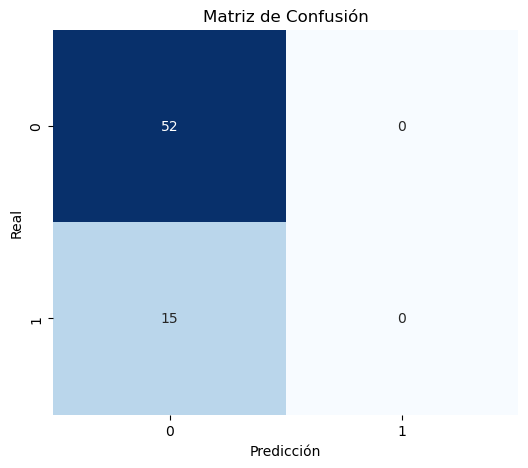

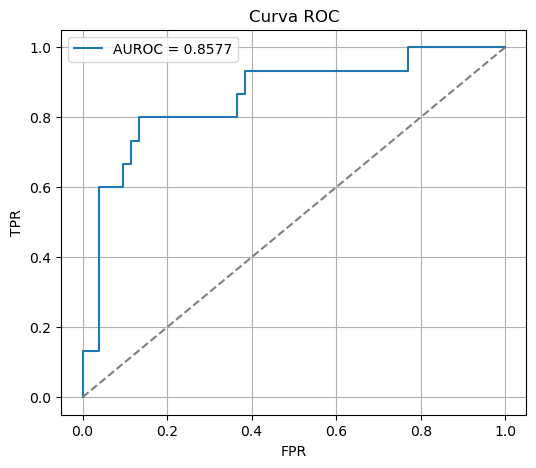

In [90]:
print('Estudiando Valores de: ', variable_name)
print('Lista de Valores: ', variable_values)
history_list = [] 
metrics_list = []
dataset_list = []
for value in variable_values:
    print('\n','*'*60,'\n\tIniciando Simulación para ', variable_name, '=', value, '\n','*'*60)
    variable_category[variable_name] = value
    """
    if value == 'anat':
        SPLIT_CONFIG["filter_clase"] = 'FLAIR'
        DATASET_CONFIG['output_shape'] = (256,256,64)
    elif value == 'func':
        SPLIT_CONFIG["filter_clase"] = 'VentralVisual'
        DATASET_CONFIG['output_shape'] = None
    elif value == 'pet':  
        SPLIT_CONFIG["filter_clase"] = '18FAV45'
        DATASET_CONFIG['output_shape'] = (128,128,64)
    else:
        SPLIT_CONFIG["filter_clase"] = None
        DATASET_CONFIG['output_shape'] = None
    """
    history, metrics, datasets_dict = full_Training(DATASET_CONFIG, SPLIT_CONFIG, MODEL_CONFIG, TRAINING_CONFIG, 
                                                   arquitecture       = ARQUITECTURE, device = DEVICE,
                                                   dataset_restart    = False,
                                                   dataset_restart_0  = True,
                                                   datasets_dict      = datasets_dict,
                                                   model_restart      = True
                                                   )
    history_list.append(history)
    metrics_list.append(metrics)
    dataset_list.append(datasets_dict)

   Loss  Accuracy  Precision    Recall  F1 Score     auroc  \
0   0.0  0.776119   0.602361  0.776119  0.678289  0.857692   

                   cm  learning_rate  
0  [[52, 0], [15, 0]]         0.0001  
0    0.0001
Name: learning_rate, dtype: float64


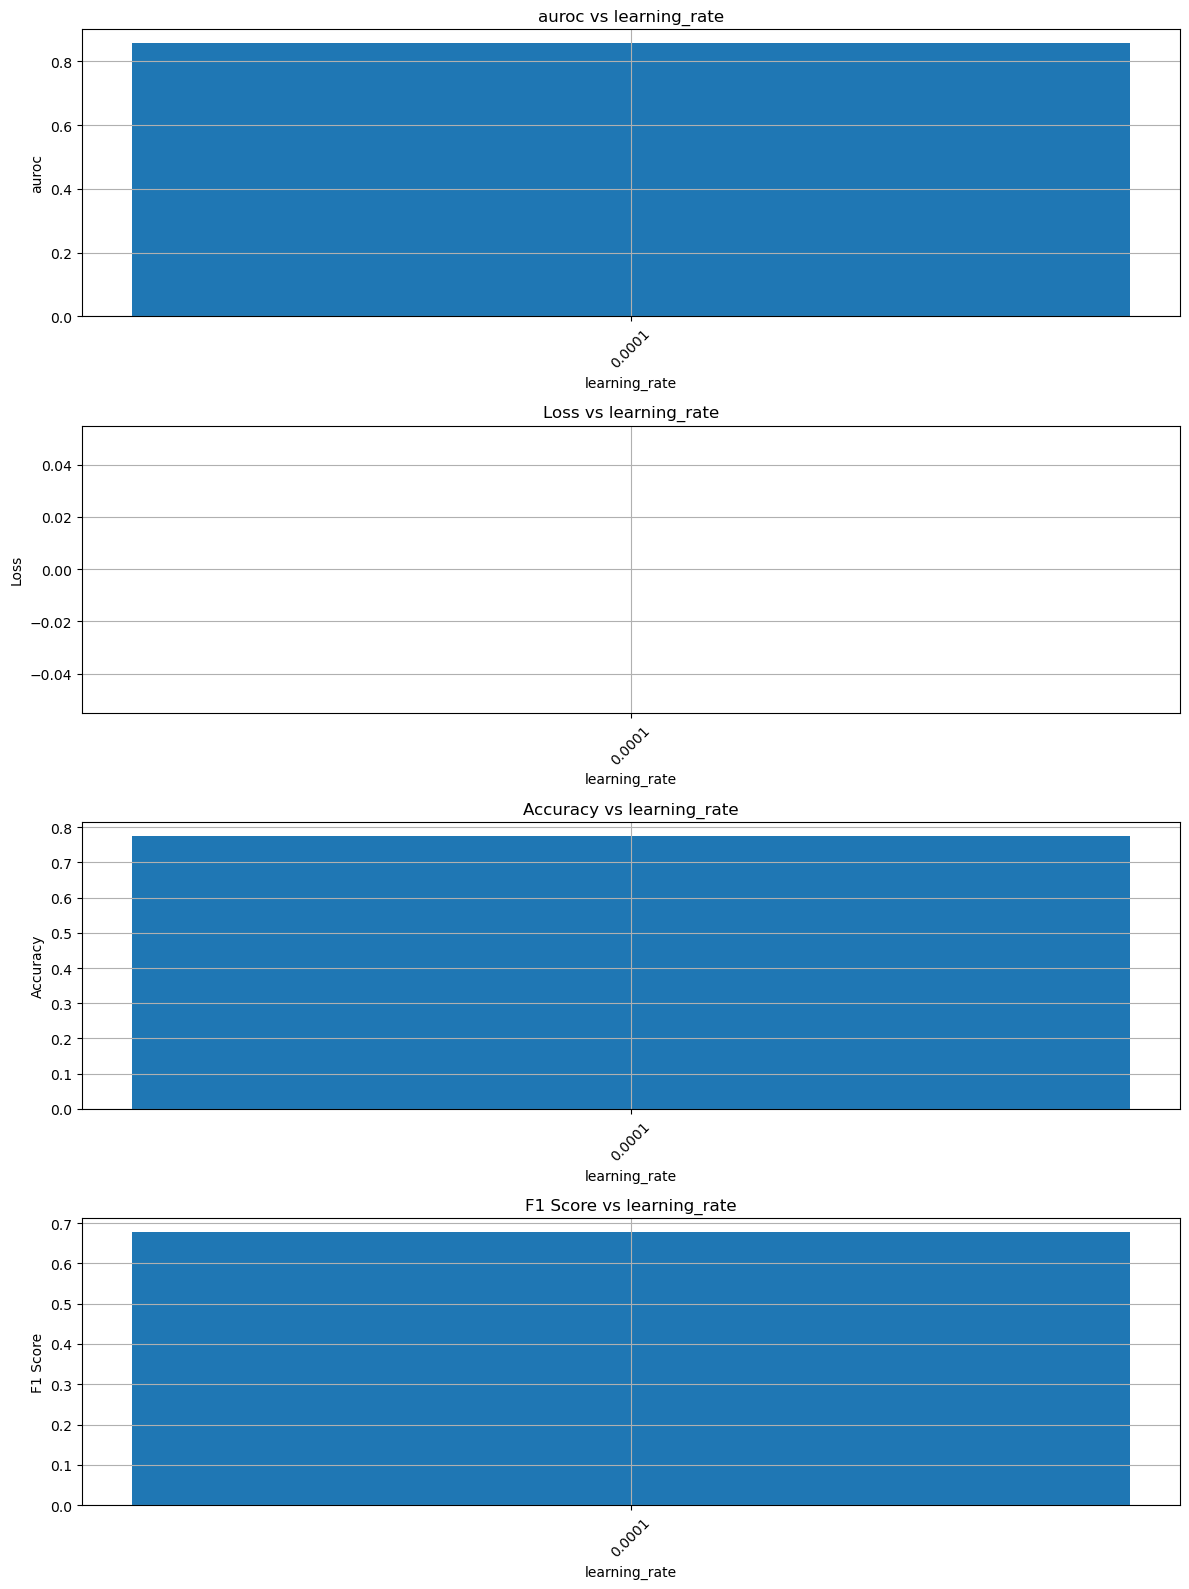

In [91]:
N = len(metrics_list)
variable_values =variable_values[:N]

df_metrics = pd.DataFrame(metrics_list)
df_metrics[variable_name] = variable_values
print(df_metrics)
metrics_to_plot = ["auroc", "Loss", "Accuracy", "F1 Score"]  # o cualquier subconjunto
print(df_metrics[variable_name])

plt.figure(figsize=(12, 4 * len(metrics_to_plot)))
category_labels = [str(p) for p in variable_values] 
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(len(metrics_to_plot), 1, i)
    plt.bar(category_labels, df_metrics[metric], width=0.05 if variable_name == "dropout" else 0.5, align='center')
    plt.xlabel(variable_name)
    plt.ylabel(metric)
    plt.title(f"{metric} vs {variable_name}")
    plt.grid(True)
    #plt.xticks(x[::4])
    plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()
df_metrics.to_csv(f'resultados_{variable_name}.csv')

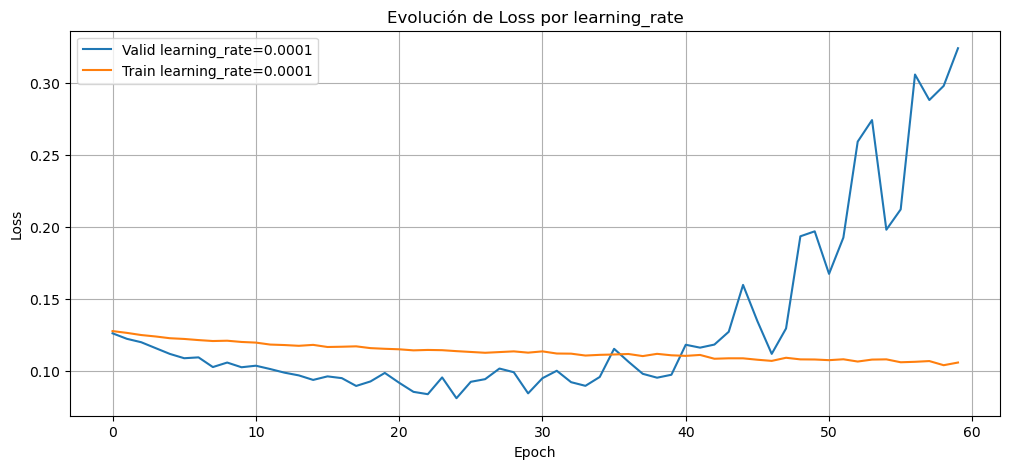

In [92]:
plt.figure(figsize=(12, 5))
for i, hist in enumerate(history_list):
    if i < 4:
        val_loss = hist["val_loss"]
        train_loss = hist["train_loss"]
        plt.plot(range(len(val_loss)), val_loss, label=f"Valid {variable_name}={variable_values[i]}")
        plt.plot(range(len(train_loss)), train_loss, label=f"Train {variable_name}={variable_values[i]}")
        #if i>0: break
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Evolución de Loss por {variable_name}")
plt.legend()
plt.grid(True)
plt.show()

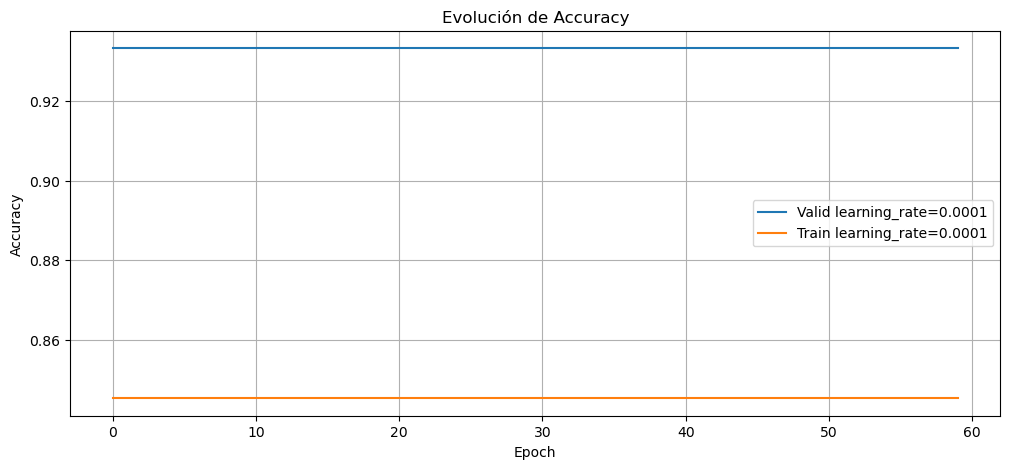

In [81]:
plt.figure(figsize=(12, 5))
for i, hist in enumerate(history_list):
    if i <3:
        train_accuracy = hist["train_accuracy"]
        val_accuracy = hist["val_accuracy"]
        plt.plot(range(len(val_accuracy)), val_accuracy, label=f"Valid {variable_name}={variable_values[i]}")
        plt.plot(range(len(train_accuracy)), train_accuracy, label=f"Train {variable_name}={variable_values[i]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Evolución de Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [44]:

# Reshape a (8,8)
heatmap = torch.Tensor(df_metrics['auroc']).view(8,8)

# Visualización
plt.imshow(heatmap, cmap='viridis') 
plt.colorbar(label='Value')
plt.title('Auroc')
plt.show()

RuntimeError: shape '[8, 8]' is invalid for input of size 1

# 6. Interpretabilidad

## 6.1. Grad-CAM

In [ ]:
def compute_gradcam_3d(model, input_tensor, target_class, device):
    model.eval()
    input_tensor = input_tensor.to(device).requires_grad_()

    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    # ⚠ Asegúrate de eliminar hooks previos si vuelves a ejecutar
    if hasattr(model, "_gradcam_fwd_hook"):
        model._gradcam_fwd_hook.remove()
    if hasattr(model, "_gradcam_bwd_hook"):
        model._gradcam_bwd_hook.remove()

    # Registra hooks y guarda referencias
    model._gradcam_fwd_hook = model.last_conv.register_forward_hook(forward_hook)
    model._gradcam_bwd_hook = model.last_conv.register_full_backward_hook(backward_hook)

    # Forward + backward
    output = model(input_tensor)
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    # Extrae y computa Grad-CAM
    act = activations[0]
    grad = gradients[0]
    weights = grad.mean(dim=(2, 3, 4), keepdim=True)
    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = cam / (cam.max() + 1e-8)

    # Limpieza
    model._gradcam_fwd_hook.remove()
    model._gradcam_bwd_hook.remove()

    return cam.cpu()

In [ ]:
def show_gradcam_slices(cam, axis=0, cmap='hot'):
    import matplotlib.pyplot as plt
    cam = cam.squeeze(0).squeeze(0)
    n_slices = cam.shape[axis]
    
    step = max(n_slices // 8, 1)
    
    fig, axs = plt.subplots(1, 8, figsize=(20, 3))
    for i, idx in enumerate(range(0, n_slices, step)[:8]):
        if axis == 0:
            img = cam[idx, :, :]
        elif axis == 1:
            img = cam[:, idx, :]
        else:
            img = cam[:, :, idx]
        axs[i].imshow(img, cmap=cmap)
        axs[i].axis('off')
        axs[i].set_title(f"Slice {idx}")
    plt.tight_layout()
    plt.show()

In [ ]:
checkpoint = torch.load('best_model.pth', weights_only=False, map_location='cpu')
model_grad = checkpoint['model']()
#model_grad = get_Model('CNN', MODEL_CONFIG).to(DEVICE).eval()
model_grad.load_state_dict(checkpoint['model_state_dict'])
#model_grad = model


In [ ]:
idx = 10
sample, label, tipo, ID, hoja = datasets_dict['test'][idx]  
print(f"Label real: {label.item()}")

input_tensor = sample.unsqueeze(0).to(DEVICE)  # [1, 1, D, H, W]
with torch.no_grad():
    output = model_grad(input_tensor)
    pred_label = torch.argmax(output, dim=1).item()
    prob = torch.softmax(output, dim=1)[0, pred_label].item()
print(f"Predicción: {pred_label}, Probabilidad: {prob:.3f}")

cam = compute_gradcam_3d(model_grad, input_tensor, pred_label, device=DEVICE)
show_gradcam_slices(cam, axis=0)
show_gradcam_slices(cam, axis=1)
show_gradcam_slices(cam, axis=2)

## 6.2. LIME

In [ ]:
from lime import lime_image
from skimage.segmentation import slic

explainer = lime_image.LimeImageExplainer()
volume = next(iter(datasets_dict['test']))[0]
volume = datasets_dict['test'].__getitem__(idx = 10)[0]
_, H, W, D = volume.shape
# Seleccionamos un slice axial (por ejemplo, en la mitad del eje Z)
z = volume.shape[-1] // 2
slice_2d = volume[0, :, :, z]  # (H, W)

# LIME espera (H, W, 3), por lo que duplicamos canales si es necesario
slice_2d = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min())
slice_rgb = np.stack([slice_2d.cpu()]*3, axis=-1)
model = model.cpu()
# Función wrapper para predicción
def predict_fn(images):
    # Convierte cada imagen RGB 2D de vuelta a formato (1, H, W, D) para tu modelo
    preds = []
    for img in images:
        mono = img[..., 0]  # usamos un solo canal
        vol = np.zeros((1, H, W, D))  # reconstruye volumen dummy
        vol[0, :, :, z] = mono
        pred = model(torch.tensor(vol).float().unsqueeze(0))  # Batch=1
        preds.append(pred.detach().numpy()[0])
    return np.array(preds)

# Ejecutar LIME sobre el slice
def custom_segmentation_fn(image):
    return slic(image, n_segments=200, compactness=0.2, sigma=1)
    
explanation = explainer.explain_instance(
    slice_rgb,
    classifier_fn=predict_fn,
    segmentation_fn=custom_segmentation_fn,
    top_labels=1,
    hide_color=0,
    #positive_only=False,
    num_samples=3000,     # Más muestras para mejor ajuste local
    num_features=15       # Más regiones explicadas
)

In [ ]:
from skimage.segmentation import mark_boundaries

# Selecciona el label que quieres explicar (por ejemplo, el más probable)
label_to_show = explanation.top_labels[0]

# Obtiene la imagen con la máscara de explicación
image_with_mask, mask = explanation.get_image_and_mask(
    label=label_to_show,
    positive_only=True,         # Mostrar solo las zonas que contribuyen positivamente
    hide_rest=False,            # Mantener el fondo visible
    num_features=10,            # Número de superpíxeles destacados
    min_weight=0.0              # Umbral mínimo para mostrar
)

# Visualizar
plt.figure(figsize=(6, 6))
image_with_mask = np.clip(image_with_mask, 0, 1)
plt.imshow(mark_boundaries(image_with_mask, mask))
plt.title(f'LIME explanation for class {label_to_show}')
plt.axis('off')
plt.show()

In [ ]:

validate_model(model, 'best_model.pth', datasets_dict, batch_size, device, debug = True, save_path = None)